In [1]:
%load_ext autoreload
%autoreload 2
#pip install -U python-dotenv


In [2]:
%run ../nb_config.py  # place a .py to set root_path in order to be able to import from src folder

running notebook configuration


In [3]:
path=os.environ.get('LOCAL_PATH')

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_squared_error, accuracy_score

from src.data_api import sources
from src import utils

from src import data_preparation as dataprep

import pandas as pd
import numpy as np

import random as rd

import seaborn as sns


state = rd.getstate()
rd.setstate(state)
 

In [5]:
conf = utils.get_conf()

# Load Data

In [6]:
wiki_prices_o=pd.read_csv(path+"data/raw/WIKI_PRICES.csv")


In [7]:
wiki_prices=wiki_prices_o.copy()

In [8]:
wiki_prices=wiki_prices[["date","ticker","adj_close"]]

In [9]:
#lets consider operations with 5 days horizon
tau=5

In [31]:

wiki_prices["lag_adj_close"]=wiki_prices.groupby("ticker")["adj_close"].shift(tau)
wiki_prices["diff"]=wiki_prices.groupby("ticker")["adj_close"].diff(tau)
wiki_prices["diff_target"]=wiki_prices.groupby("ticker")["diff"].shift(-tau)
 
wiki_prices["lreturn"]=np.log(wiki_prices["adj_close"]) - np.log(wiki_prices["lag_adj_close"])
wiki_prices["lreturn_target"]=wiki_prices.groupby("ticker")["lreturn"].shift(-tau)

In [10]:
wiki_prices.head(15)

,date,ticker,adj_close
0,1999-11-18,A,30.0186
1,1999-11-19,A,27.5489
2,1999-11-22,A,30.0186
3,1999-11-23,A,27.4602
4,1999-11-24,A,28.0128
5,1999-11-26,A,28.1015
6,1999-11-29,A,28.7428
7,1999-11-30,A,28.7837
8,1999-12-01,A,29.2954
9,1999-12-02,A,30.1073


In [33]:

##filtro fechas 
wiki_prices=wiki_prices.pipe(dataprep.pl_filter, column="date", start_dt='2016-01-01', end_dt='2018-02-01')
wiki_prices=wiki_prices.fillna(0)
#wiki_prices=wiki_prices.set_index(["ticker", "date"])

In [34]:
wiki_prices.head(10)

,index,date,ticker,adj_close,lag_adj_close,diff,diff_target,lreturn,lreturn_target
0,4055,2016-01-04,A,39.9828,41.2940,-1.3112,-2.7022,-0.0323,-0.0700
1,4056,2016-01-05,A,39.8452,40.9412,-1.0960,-2.3190,-0.0271,-0.0600
2,4057,2016-01-06,A,40.0221,41.5096,-1.4875,-3.8027,-0.0365,-0.0998
3,4058,2016-01-07,A,38.3221,41.3234,-3.0012,-1.3658,-0.0754,-0.0363
4,4059,2016-01-08,A,37.9193,41.0833,-3.1640,-1.4543,-0.0801,-0.0391
5,4060,2016-01-11,A,37.2806,39.9828,-2.7022,-0.7271,-0.0700,-0.0197
6,4061,2016-01-12,A,37.5262,39.8452,-2.3190,-0.9138,-0.0600,-0.0247
7,4062,2016-01-13,A,36.2193,40.0221,-3.8027,0.3636,-0.0998,0.0100
8,4063,2016-01-14,A,36.9563,38.3221,-1.3658,0.3636,-0.0363,0.0098
9,4064,2016-01-15,A,36.4650,37.9193,-1.4543,0.4913,-0.0391,0.0134


In [35]:
#lets create columns to compare
# doing random movements: 
#1-> long, 0 stay, -1 short


In [36]:
wiki_prices["rd_movement"]= pd.Series(rd.choices([1,0,-1], k=wiki_prices.shape[0]))

In [37]:
wiki_prices.head(6)

,index,date,ticker,adj_close,lag_adj_close,diff,diff_target,lreturn,lreturn_target,rd_movement
0,4055,2016-01-04,A,39.9828,41.2940,-1.3112,-2.7022,-0.0323,-0.0700,1
1,4056,2016-01-05,A,39.8452,40.9412,-1.0960,-2.3190,-0.0271,-0.0600,1
2,4057,2016-01-06,A,40.0221,41.5096,-1.4875,-3.8027,-0.0365,-0.0998,-1
3,4058,2016-01-07,A,38.3221,41.3234,-3.0012,-1.3658,-0.0754,-0.0363,-1
4,4059,2016-01-08,A,37.9193,41.0833,-3.1640,-1.4543,-0.0801,-0.0391,-1
5,4060,2016-01-11,A,37.2806,39.9828,-2.7022,-0.7271,-0.0700,-0.0197,0


In [38]:
# always buying/always selling

wiki_prices["all_long"]= 1
wiki_prices["all_short"]= -1

#allways doing what the sign tell

wiki_prices["sign"]= np.sign(wiki_prices["diff"])


In [39]:
wiki_prices.describe()

,index,adj_close,lag_adj_close,diff,diff_target,lreturn,lreturn_target,rd_movement,all_long,all_short,sign
count,"1,388,057.0000","1,388,057.0000","1,388,057.0000","1,388,057.0000","1,388,057.0000","1,388,057.0000","1,388,057.0000","1,388,057.0000","1,388,057.0000","1,388,057.0000","1,388,057.0000"
mean,"7,776,982.7254",141.0139,140.4301,0.5797,0.5010,0.0018,0.0019,-0.0002,1.0000,-1.0000,0.0716
std,"4,427,087.6075","4,750.7534","4,725.9595",88.7764,100.8393,0.0687,0.0688,0.8164,0.0000,0.0000,0.9917
min,"4,055.0000",0.0100,0.0000,"-9,919.9900","-37,900.0000",-2.9621,-2.9621,-1.0000,1.0000,-1.0000,-1.0000
25%,"3,993,660.0000",13.2610,13.2400,-0.4765,-0.4741,-0.0207,-0.0206,-1.0000,1.0000,-1.0000,-1.0000
50%,"7,822,241.0000",28.9000,28.8209,0.0500,0.0500,0.0026,0.0025,0.0000,1.0000,-1.0000,1.0000
75%,"11,625,556.0000",56.2204,56.0344,0.7204,0.7209,0.0259,0.0258,1.0000,1.0000,-1.0000,1.0000
max,"15,389,276.0000","325,915.0000","324,064.0000","20,315.0000","20,315.0000",5.5215,5.5215,1.0000,1.0000,-1.0000,1.0000


In [42]:
wiki_prices.head(7)

,index,date,ticker,adj_close,lag_adj_close,diff,diff_target,lreturn,lreturn_target,rd_movement,all_long,all_short,sign
0,4055,2016-01-04,A,39.9828,41.2940,-1.3112,-2.7022,-0.0323,-0.0700,1,1,-1,-1.0000
1,4056,2016-01-05,A,39.8452,40.9412,-1.0960,-2.3190,-0.0271,-0.0600,1,1,-1,-1.0000
2,4057,2016-01-06,A,40.0221,41.5096,-1.4875,-3.8027,-0.0365,-0.0998,-1,1,-1,-1.0000
3,4058,2016-01-07,A,38.3221,41.3234,-3.0012,-1.3658,-0.0754,-0.0363,-1,1,-1,-1.0000
4,4059,2016-01-08,A,37.9193,41.0833,-3.1640,-1.4543,-0.0801,-0.0391,-1,1,-1,-1.0000
5,4060,2016-01-11,A,37.2806,39.9828,-2.7022,-0.7271,-0.0700,-0.0197,0,1,-1,-1.0000
6,4061,2016-01-12,A,37.5262,39.8452,-2.3190,-0.9138,-0.0600,-0.0247,-1,1,-1,-1.0000


In [45]:
print("max possible : " ,(np.abs(wiki_prices["diff_target"]).sum()))
print("total rd : " ,(wiki_prices["diff_target"]*wiki_prices["rd_movement"]).sum())
print("total all_long : " ,(wiki_prices["diff_target"]*wiki_prices["all_long"]).sum())
print("total all_short : " ,(wiki_prices["diff_target"]*wiki_prices["all_short"]).sum())
print("total current 5 sign : " ,(wiki_prices["diff_target"]*wiki_prices["sign"]).sum())
#print("total current ln5 sign : " ,(wiki_prices["diff"]*wiki_prices["sign"]).sum())

max possible :  3812326.329937344
total rd :  61915.41417905741
total all_long :  695442.9633896977
total all_short :  -695442.9633896977
total current 5 sign :  340347.8306988135


(array([636365.,      0.,      0.,      0.,      0.,  15873.,      0.,
             0.,      0., 735819.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

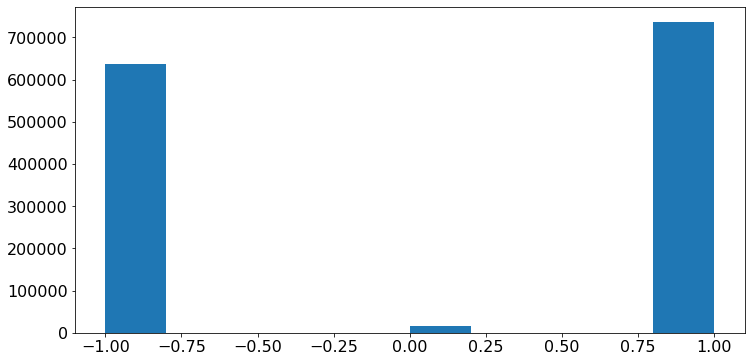

In [43]:
# distribución sign
plt.hist(wiki_prices["sign"].astype("category"))


## USING LOG RETURNS

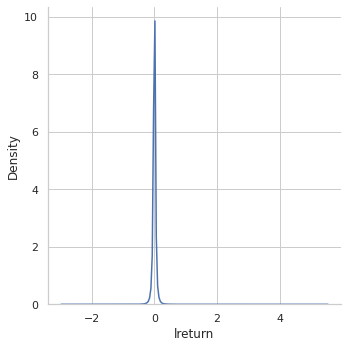

In [50]:
sns.displot(wiki_prices, x=wiki_prices["lreturn"], kind="kde")


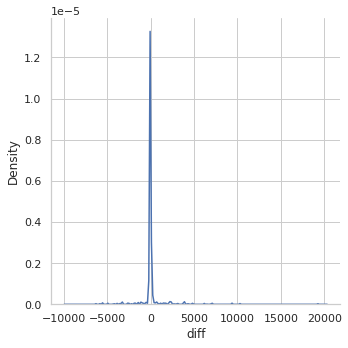

In [51]:
sns.displot(wiki_prices, x=wiki_prices["diff"], kind="kde")


In [55]:
wiki_prices.lreturn.describe()

count   1,388,057.0000
mean            0.0018
std             0.0687
min            -2.9621
25%            -0.0207
50%             0.0026
75%             0.0259
max             5.5215
Name: lreturn, dtype: float64

In [73]:
#lets make 0.01 intervals
thresholds=np.arange(0, 1, 0.01).tolist()
total_gain=[]

In [74]:
for th in thresholds:
    movement =   wiki_prices["lreturn"].apply(lambda x: np.sign(x) if np.abs(x)>th else 0)
    total_gain.append((wiki_prices["diff_target"]*movement ).sum())

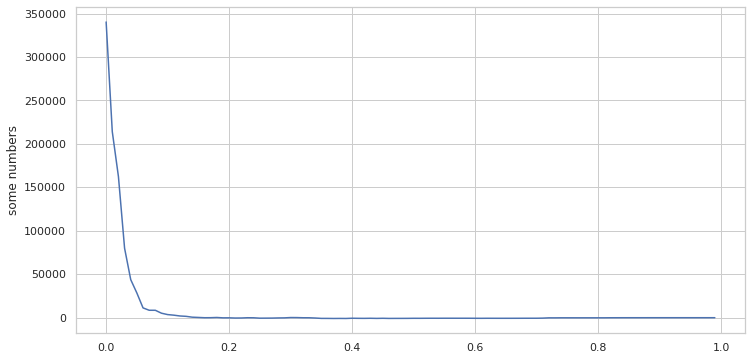

In [76]:
plt.plot(thresholds,total_gain)
plt.ylabel('some numbers')
plt.show()

In [ ]:
# more we bet more we gain 